# **PREDICTING GRADES FROM CHATGTP PROMPTS**

Predicting Grades of students by Analyzing chatgtp prompts

In [ ]:
# Import libraries
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
!pip install skrebate


  Preparing metadata (setup.py) ... done
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=545e8af9ea05ecc523ff367c5cfdcf59402d3354f19d48d29ade253a91ff4169
  Stored in directory: /root/.cache/pip/wheels/dd/67/40/683074a684607162bd0e34dcf7ccdfcab5861c3b2a83286f3a
Successfully built skrebate


In [ ]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.1 MB/s eta 0:00:00


In [ ]:
data_path = "data/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 123/123 [00:20<00:00,  5.89it/s]


In [ ]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### **Prompt Matching Prompt matching with questions**
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching
#### **Our approach**
use word2vec instead of tf_idf here

In [ ]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [ ]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [ ]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [ ]:
################################################################################
################################################################################
#I am trying to use word2vec instead of tf_idf here
#THIS IS OUR ATTEMPT IN IMPROVING CODE
################################################################################
################################################################################

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import numpy as np
import pandas as pd

# Function to preprocess text for Word2Vec
def preprocess_text(text):
    # Convert text to lowercase and split it into words
    words = text.lower().split()
    # Remove stop words
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    return words

prompts = []
code2prompts = defaultdict(list)
for code, convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

# Create a list of sentences for Word2Vec training
sentences = [preprocess_text(prompt) for prompt in prompts + questions]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create DataFrames for Word2Vec vectors
questions_word2vec = pd.DataFrame([word2vec_model.wv[preprocess_text(question)].mean(axis=0) for question in questions])

code2prompts_word2vec = {}
for code, user_prompts in code2prompts.items():
    prompts_word2vec = [word2vec_model.wv[preprocess_text(prompt)].mean(axis=0) for prompt in user_prompts if preprocess_text(prompt)]
    if prompts_word2vec:
        code2prompts_word2vec[code] = pd.DataFrame(prompts_word2vec)
    else:
        print(f"This file is erronous: {code}")

# Concatenate DataFrames along rows and handle NaN values
code2prompts_word2vec = {code: df.fillna(0) for code, df in code2prompts_word2vec.items()}

This file is erronous: 139235c7-736c-4237-92f0-92e8c116832c
This file is erronous: 668ad17e-0240-49f7-b5a7-d22e502554c6
This file is erronous: b0640e51-6879-40cb-a4f5-329f952ef99d
This file is erronous: da6b70d5-29f6-491a-ad46-037c77067128


In [ ]:
################################################################################
################################################################################
#THIS IS OUR ATTEMPT IN IMPROVING CODE
################################################################################
################################################################################

code2prompts_word2vec["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.123909,0.562992,0.210558,-0.135721,-0.125405,-0.801614,-0.076309,0.810394,-0.055977,-0.129539,...,0.296709,0.160877,-0.013118,0.133158,0.546789,0.519062,0.129730,-0.336279,0.092554,0.096079
1,-0.141580,0.335187,0.396837,-0.270868,-0.105787,-0.620552,-0.181399,0.706981,0.067420,-0.139499,...,0.582298,-0.058133,-0.084040,0.181759,0.279013,0.514321,0.231408,-0.167667,-0.107838,0.410848
2,-0.554784,1.124660,-0.220128,-0.605761,0.113008,-1.376443,-0.220961,1.842704,-0.201811,-0.328059,...,0.574306,-0.039745,-0.424096,-0.038818,0.688171,0.554537,0.560330,-1.086942,-0.093638,0.418029
3,-1.073498,0.806928,-0.258431,-0.990370,-0.304801,-1.250672,0.083614,1.875064,0.225853,-0.936918,...,1.250543,-0.135252,-0.038512,0.035982,0.945110,0.832312,0.262122,-1.268691,0.435921,0.248511
4,-0.648313,0.521057,-0.082180,-0.565300,-0.212975,-0.844071,0.053323,1.081397,0.091328,-0.555556,...,0.789808,-0.025853,-0.012228,0.003351,0.581776,0.504601,0.173277,-0.771441,0.267729,0.073540


In [ ]:
################################################################################
################################################################################
#THIS IS OUR ATTEMPT IN IMPROVING CODE
################################################################################
################################################################################

code2prompts_word2vec["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 100)

In [ ]:
################################################################################
################################################################################
#IMPROVING CODE
################################################################################
################################################################################

from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between questions_word2vec and each code's prompts_word2vec
code2similarity = {}

for code, prompts_df in code2prompts_word2vec.items():
    similarity_scores = cosine_similarity(prompts_df, questions_word2vec)
    # Average similarity scores across prompts for each code
    avg_similarity_score = similarity_scores.mean(axis=0)
    code2similarity[code] = avg_similarity_score

# Create a DataFrame to store the similarity scores
similarity_df = pd.DataFrame(code2similarity, index=questions)

# Display the resulting DataFrame
print(similarity_df)

                                                    0031c86e-81f4-4eef-9e0e-28037abf9883  \
Initialize\n*   First make a copy of the notebo...                              0.881974   
Load training dataset (5 pts)\n    *  Read the ...                              0.820296   
Understanding the dataset & Preprocessing (15 p...                              0.816036   
Set X & y, split data (5 pts)\n\n*   Shuffle th...                              0.833983   
Features and Correlations (10 pts)\n\n* Correla...                              0.827928   
Tune Hyperparameters (20 pts)\n* Choose 2 hyper...                              0.701354   
Re-train and plot the decision tree with the hy...                              0.711770   
Test your classifier on the test set (20 pts)\n...                              0.754003   
Find the information gain on the first split (1...                              0.724698   

                                                    0225686d-b825-4cac-8691-3a3

In [ ]:
################################################################################
################################################################################
#IMPROVING CODE
################################################################################
################################################################################

code2questionmapping = dict()
for code, cosine_scores in similarity_df.items():
    code2questionmapping[code] = similarity_df[code].tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.881974,0.820296,0.816036,0.833983,0.827928,0.701354,0.711770,0.754003,0.724698
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.829642,0.803015,0.775231,0.771370,0.732495,0.744794,0.763328,0.786915,0.753760
2,041f950b-c013-409a-a642-cffff60b9d4b,0.885490,0.809184,0.748324,0.761018,0.784998,0.755193,0.755580,0.778502,0.734941
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.850590,0.812478,0.810071,0.803253,0.765241,0.738500,0.747432,0.780569,0.746349
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.874140,0.820065,0.799804,0.798216,0.771730,0.754703,0.757560,0.785927,0.759624
...,...,...,...,...,...,...,...,...,...,...
114,e779a2d6-6e4e-4ade-8a30-d624166c2ab3,0.823504,0.799458,0.776252,0.766732,0.688471,0.726107,0.732776,0.766600,0.724917
115,e8fd2278-1620-432d-81cb-02cac8543456,0.894463,0.874818,0.825811,0.807629,0.737454,0.807919,0.837501,0.862677,0.809255
116,ebe86296-3cae-429a-9a7c-aa8f21cfd7cb,0.861001,0.831089,0.810004,0.796400,0.737765,0.773321,0.782856,0.810622,0.765292
117,ef5b3fbc-f5d2-4446-bb4f-7d8b2a3026e9,0.844547,0.797521,0.768176,0.764359,0.727560,0.728319,0.746762,0.774249,0.773365


#### **Feature Engineering**
- Number of prompts that a users asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

#### **Feature Engineering**
Approach to extracting more features that can be useful to the model.

In [ ]:
################################################################################
################################################################################
#IMPROVING CODE
################################################################################
################################################################################
keywords2search = [ "Information", "Gain", "First", "Split","error", "no", "thank", "next", "Entropy"]
keywords2search = [k.lower() for k in keywords2search]

In [ ]:
################################################################################
################################################################################
#IMPROVING CODE
################################################################################
################################################################################

### Using pattern based approach in the structure of the sentences to tell if it is an error or not

code2features = defaultdict(lambda : defaultdict(int))

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # check if it is an error term or not ## improvement
            #if is_fix_error_prompt(text) == True :
             #   code2features[code]['error']  = code2features[code]['error'] +1
            #else:
             #  code2features[code]['error']  = code2features[code]['error']

            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)


        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)



        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [ ]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#shape,#variables,#missing,#encode,#labels,#split,#data,#shuffle,#separate,...,#information,#gain,#first,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,1.0,0.0,1.0,3.0,1.0,2.0,6.0,1.0,1.0,...,0.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,2.0,0.0,1.0,1.0,2.0,4.0,3.0,1.0,0.0,...,3.0,2.0,2.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,2.0,2.0,8.0,6.0,2.0,0.0,...,3.0,3.0,4.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,2.0,1.0,1.0,4.0,0.0,2.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,4.0,3.0,4.0,2.0,2.0,16.0,10.0,3.0,0.0,...,4.0,4.0,10.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In [ ]:
# reading the scores
scores = pd.read_csv("/content/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


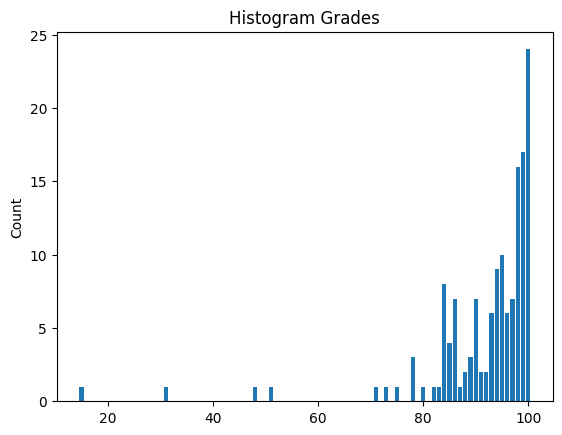

In [ ]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [ ]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#shape,#variables,#missing,#encode,#labels,#split,#data,#shuffle,...,#information,#gain,#first,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,1.0,0.0,1.0,3.0,1.0,2.0,6.0,1.0,...,0.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,2.0,0.0,1.0,1.0,2.0,4.0,3.0,1.0,...,3.0,2.0,2.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,2.0,2.0,8.0,6.0,2.0,...,3.0,3.0,4.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,2.0,1.0,1.0,4.0,0.0,2.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,4.0,3.0,4.0,2.0,2.0,16.0,10.0,3.0,...,4.0,4.0,10.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In [ ]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#shape,#variables,#missing,#encode,#labels,#split,#data,#shuffle,...,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,1.0,0.0,1.0,3.0,1.0,2.0,6.0,1.0,...,212.206370,0.154449,0.295377,0.522530,0.353280,0.460738,0.554093,0.167517,0.183185,0.195389
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,2.0,0.0,1.0,1.0,2.0,4.0,3.0,1.0,...,113.633582,0.192349,0.793501,0.771941,0.882341,0.606933,0.987461,0.892424,0.570782,0.543683
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,2.0,2.0,8.0,6.0,2.0,...,17.187601,0.259177,0.295831,0.624788,0.352145,0.642884,0.454297,0.540720,0.546932,0.326287
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,2.0,1.0,1.0,4.0,0.0,2.0,...,107.092566,0.147280,0.117291,0.266282,0.316882,0.334370,0.309032,0.192168,0.262624,0.408428
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,4.0,3.0,4.0,2.0,2.0,16.0,10.0,3.0,...,18.850913,0.343972,0.575004,0.782414,0.624944,0.724370,0.872061,0.686087,0.945200,0.511475


In [ ]:
# Merge the Features
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#shape,#variables,#missing,#encode,#labels,#split,#data,#shuffle,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,1.0,0.0,1.0,3.0,1.0,2.0,6.0,1.0,...,0.154449,0.295377,0.522530,0.353280,0.460738,0.554093,0.167517,0.183185,0.195389,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,2.0,0.0,1.0,1.0,2.0,4.0,3.0,1.0,...,0.192349,0.793501,0.771941,0.882341,0.606933,0.987461,0.892424,0.570782,0.543683,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,2.0,2.0,8.0,6.0,2.0,...,0.259177,0.295831,0.624788,0.352145,0.642884,0.454297,0.540720,0.546932,0.326287,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,2.0,1.0,1.0,4.0,0.0,2.0,...,0.147280,0.117291,0.266282,0.316882,0.334370,0.309032,0.192168,0.262624,0.408428,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,4.0,3.0,4.0,2.0,2.0,16.0,10.0,3.0,...,0.343972,0.575004,0.782414,0.624944,0.724370,0.872061,0.686087,0.945200,0.511475,100.0


In [ ]:
# Set the features and target variables
X = temp_df[temp_df.columns[1:-1]]
y = temp_df["grade"]
print(X.shape, y.shape)

(118, 53) (118,)


#### **Apply feature subset selection algorithm**
in this case releif algorithm is chosen as the feature subset selection.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (94, 53)
Shape of X_test: (24, 53)
Shape of y_train: (94,)
Shape of y_test: (24,)


In [ ]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



# Create a DataFrame with the features and target variable
df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
df["grade"] = y

# Calculate the correlation between features and the target variable
correlation_scores = df.corr()["grade"].abs().sort_values(ascending=False)

# Select the top 10 features based on correlation
top_features = correlation_scores[1:11].index  # Exclude the target variable
X_selected = df[top_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train a model (Random Forest in this example) using the selected features
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the names of the top 10 selected features
print("Top 10 Selected Features:", top_features[:10])

In [ ]:
X_train.columns

Index(['feature_5', 'feature_18', 'feature_1', 'feature_10', 'feature_11',
       'feature_4', 'feature_6', 'feature_0', 'feature_2', 'feature_12'],
      dtype='object')

In [ ]:
#select best subset according to selection
selected_features_indices = [5, 18, 1, 10, 11, 4, 6, 0, 2, 12]
X_train_selected = X_train.iloc[:, selected_features_indices]
X_test_selected = X_test.iloc[:, selected_features_indices]

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train_selected.shape)
print("Shape of X_test:", X_test_selected.shape)

### **Model Building**
build an appropriate machine learning model to predict the scores of students from the seleted features
#### **Our approach**
XGboost ( extreme gradient boosting)

In [ ]:
################################################################################
################################################################################
#IMPROVING CODE
################################################################################
################################################################################
# Using XGboost ro predict scores of students
import xgboost as xgb
regressor = xgb.XGBRegressor(booster = "gbtree", objective='reg:squarederror', max_depth=10, random_state=0)


In [ ]:
################################################################################
################################################################################
#IMPROVING CODE
################################################################################
################################################################################
#fit the model
regressor.fit(X_train_selected, y_train)
# Prediction
y_train_pred = regressor.predict(X_train_selected)
y_test_pred = regressor.predict(X_test_selected)

In [ ]:
# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

Alternatively
Use random Forest , Linear regression with Lasso regression (skip feature subset selection in this case)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score



# Initialize and train the Random Forest regressor
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
reg_rf.fit(X_train_selected , y_train)

# Predict target values on the test set
y_pred_rf = reg_rf.predict(X_test_selected )

# Evaluate the Random Forest regressor
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the results
print("Random Forest Mean Squared Error:", mse_rf)
print("Random Forest R-squared Score:", r2_rf)
